# Initialisation du système

**a) Réseau discussion:**  
Nous initialisons **une matrice** de $ N\_1dim*N\_1dim=N $ individus. De plus, nous modélisons un réseau discussion par **un dictionaire**, qui associe à chaque individu un tuple, de la forme $ dict[str:tuple[int,bool,float,float]] $. Celui-ci représentera intégralement un agent et ses caractéristiques.

On rappelle la description d'un agent : 

|Caractéristique||Nom    |Type   |Intervalle     |Valeur initiale  | Fixe ?    |
|:-------------:||:-----:|:-----:|:-------------:|:---------------:|:---------:|
|**Nom** : nom de l'agent (clé du dict)                                  ||**nom**    |str    |[str(0),str(N)]|str(k)|Oui|
|**Opinion** : y croit (1) ou non (0)                                    ||**op**     |int    |[0,1]          |0     |Non|
|**Déjà vu** : nb d'expositions à la news                                ||**deja_vu**|int   |[0,steps]   |0 |Non|
|**Force de persuasion** : capacité à convaincre qqun (accrue qd tend vers 1) ||**fp**|float  |[0,1]          |Random|Oui|
|**Conviction** : caractérise la conviction à la news (tend vers 1) ou non (tend vers 0)||**p**|float  |[0,1] |0.5   |Non| 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import random

#description d'un agent : nom:(opinion, deja_vu , force_de_persuasion , conviction)
#                         nom:(  op   , deja_vu ,       fp            ,     p     )

#VARIABLES GLOBALES / PARAMETRES DU MODELE :
N_1dim = 5                #nb d'agents sur une dimension
N = N_1dim**2             #nb d'agents total
nb_om = 10                 #nb d'organismes médiatiques (malveillants ou non)
nb_xom = 4                #nb d'organismes médiatiques malveillants
mal = nb_xom/nb_om        #degré de malveillance (= proportion de médias malveillants)
co = 7                    #degré de connectivité de l'environnement (= nb de réseaux moyen par agent = somme(nb_res) / nb_agents)
steps = 100               #nb de pas de temps
news = np.random.random() #crédibilité de la news
seuil = 0.3               #seuil

print('Crédibilité de la news :',news,'\n')

#Initialisation d'un réseau d'humains :
Reseau_discu={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
Noms_reseau_discu=[str(k) for k in range(1,N+1)]

#Initialisation d'un réseau avec des agents malveillants (temporaire)
nb_malv=6
def init_sys_avec_malv(n_1dim,nb_malv):
    
    Pop={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
    L=np.random.choice(range(1,(n_1dim**2)+1), size=nb_malv, replace=False)
    for e in L:
        Pop[str(e)]=(1,0,0.9,0.8)
    
    return Pop

Pop_malv=init_sys_avec_malv(N_1dim,nb_malv)
print('Réseau avec malveillants : \n',Pop_malv,'\n')

#Initialisation d'un système avec organismes médiatiques (malveillants et neutres):
List_om=np.random.choice(range(1,N+1), size=nb_om, replace=False)
print('Liste des médias :',List_om,'\n')

List_xom=np.random.choice(List_om, size=nb_xom, replace=False)
print('Liste des médias malveillants :',List_xom,'\n')

def init_ac_om_et_xom(reseau,list_om,list_xom):
    for name in reseau:
        if 'O' not in name and 'X' not in name:
            if int(name) in list_om and int(name) not in list_xom:
                reseau['OM'+str(name)]=(0,0,np.random.uniform(low=0.7,high=1.0),0.5)
                del reseau[name]
            if int(name) in list_xom:
                reseau['XOM'+str(name)]=(0,0,np.random.uniform(low=0.7,high=1.0),0.6)
                del reseau[name]
                
    return reseau

Pop_ac_om=init_ac_om_et_xom(Reseau_discu,List_om,List_xom)
print('Population avec médias : \n',Pop_ac_om,'\n')

#Réseau à valeurs quelconques (au milieu de la simulation par exemple) pour faire des tests :
Test_reseau={str(k):(np.random.choice([0,1]),np.random.choice(range(steps)),np.random.random_sample(),np.random.random_sample()) for k in range(1,N+1)}

#Liste/matrice des noms des agents :
    #Matrice sans médias
Noms_agents_sans=[name for name in Pop_malv]
np.random.shuffle(Noms_agents_sans)
Mat_pop_sans_om=np.reshape(Noms_agents_sans,(N_1dim,N_1dim)).copy()
print('Matrice agents (sans médias) :\n',Mat_pop_sans_om,'\n')
    #Matrice avec médias
Noms_agents_avec=[name for name in Pop_ac_om]
np.random.shuffle(Noms_agents_avec)
Mat_pop_ac_om=np.reshape(Noms_agents_avec,(N_1dim,N_1dim)).copy()
print('Matrice agents (avec médias) :\n',Mat_pop_ac_om,'\n')

#Matrice des opinions de départ :
def matrice_opinions(reseau,names,n_1dim):
    Op=np.zeros((n_1dim,n_1dim))
    i=0
    j=0
    for nom in names:
        op,deja,fp,p=reseau[nom]
        Op[i,j]=op
        if j<(n_1dim-1):
            j=j+1
        elif j==(n_1dim-1):
            j=0
            i=i+1
    return Op

print('Matrice op (avec médias) :\n',matrice_opinions(Pop_ac_om,Noms_agents_avec,N_1dim),'\n')

#Matrice des convictions de départ
def matrice_convic(reseau,names,n_1dim):
    P=np.zeros((n_1dim,n_1dim))
    i=0
    j=0
    for nom in names:
        op,deja,fp,p=reseau[nom]
        P[i,j]=p
        if j<(n_1dim-1):
            j=j+1
        elif j==(n_1dim-1):
            j=0
            i=i+1
    return P

print('Matrice p (avec médias) :\n',matrice_convic(Pop_ac_om,Noms_agents_avec,N_1dim),'\n')

Crédibilité de la news : 0.6223779710328092 

Réseau avec malveillants : 
 {'1': (0, 0, 0.6610397879567794, 0.5), '2': (0, 0, 0.17008753024734957, 0.5), '3': (0, 0, 0.31702249062114285, 0.5), '4': (0, 0, 0.7764512594215621, 0.5), '5': (0, 0, 0.6797442873434593, 0.5), '6': (0, 0, 0.9763388312978469, 0.5), '7': (1, 0, 0.9, 0.8), '8': (1, 0, 0.9, 0.8), '9': (0, 0, 0.17088684359638806, 0.5), '10': (1, 0, 0.9, 0.8), '11': (0, 0, 0.727739933291056, 0.5), '12': (0, 0, 0.6955068470851824, 0.5), '13': (0, 0, 0.4690645857986657, 0.5), '14': (0, 0, 0.955119456923377, 0.5), '15': (0, 0, 0.6188598390227845, 0.5), '16': (1, 0, 0.9, 0.8), '17': (0, 0, 0.781214650332904, 0.5), '18': (0, 0, 0.131246575642482, 0.5), '19': (0, 0, 0.12338109266521746, 0.5), '20': (0, 0, 0.09241887486060196, 0.5), '21': (1, 0, 0.9, 0.8), '22': (0, 0, 0.9121065544252922, 0.5), '23': (1, 0, 0.9, 0.8), '24': (0, 0, 0.6562746317618844, 0.5), '25': (0, 0, 0.27830820610510054, 0.5)} 

Liste des médias : [23 17  5 14  7 13 21  8 

**b) Réseaux sociaux :**  
Nous modéliserons les **10 réseaux sociaux les plus utilisés en 2017** (source : http://www.influenth.com/top-10-reseaux-sociaux-2017/) par un dictionnaire du type $ dict[str:list[str]] $ qui à un nom de réseau social associe la liste de personnes inscrites.
Nous modéliserons un réseau virtuel par **un dictionnaire** qui à chaque agent (humain ou organisme médiatique) associe une liste d'amis ou d'abonnés. Il représentera la possibilité d'interaction.

In [47]:
#RESEAUX SOCIAUX
L_reseaux=['facebook','qzone','instagram','tumblr','twitter','baidu','weibo','snapchat','pinterest','linkedin']

#Nb de réseaux par agent:
def nb_res(co,n):
    k=0
    L=[]

    while k<n-1:
        if k%2==0:
            if co<5:
                nb=np.random.choice(range(2*co+1))
            else:
                nb=np.random.choice(range(11))
            L.append(nb)
        else:
            if 2*co-nb<=10:
                L.append(2*co-nb)
            else:
                L[k-1]=L[k-1]+(2*co-nb-10)
                L.append(10)
        k=k+1
    if n%2==1:
        L.append(co)
    else:
        if 2*co-nb<=10:
            L.append(2*co-nb)
        else:
            L[k-1]=L[k-1]+(2*co-nb-10)
            L.append(10)
        
    return L

Nb_res={name : nb for (name,nb) in zip(Noms_agents_avec,nb_res(co,N))}
print('Nb de réseaux par agent :\n',Nb_res,'\n')

#Agents et les réseaux auxuels ils appartiennent:
Agents_ac_reseaux={name : list(np.random.choice(L_reseaux, size=Nb_res[name], replace=False)) for name in Noms_agents_avec}
print('Agents et les réseaux auxquels ils appartiennent :\n',Agents_ac_reseaux,'\n')

#Réseaux et leurs utilisateurs:
def res_et_ag(ag_res,reseaux):
    D=dict()
    for res in reseaux:
        D[res]=[]
        for ag in ag_res:
            if res in ag_res[ag]:
                D[res].append(ag)
    return D
    
Reseaux_ac_agents=res_et_ag(Agents_ac_reseaux,L_reseaux)
print('Reseaux et leurs utilisateurs :\n',Reseaux_ac_agents,'\n')

#Réseau virtuel (dico liste amis)
def reseau_virtu(agents_et_res,res_et_agents,nb_res):
    D=dict()
    for a in agents_et_res:
        if nb_res[a]==0:
            D[a]=[]
        else:
            for r in agents_et_res[a]:
                Amis=set(np.random.choice(res_et_agents[r],size=np.random.choice(range(len(res_et_agents[r])))))
                if a in Amis:
                    Amis.remove(a)
                D[a]=list(Amis)    
    for a in D:
        for ami in D[a]:
            if a not in D[ami] and nb_res[ami]!=0:
                D[ami].append(a)
    return D

Reseau_virtuel=reseau_virtu(Agents_ac_reseaux,Reseaux_ac_agents,Nb_res)
print('Réseau virtuel :\n',Reseau_virtuel)

Nb de réseaux par agent :
 {'9': 4, '15': 10, 'XOM7': 5, '11': 9, 'OM17': 4, 'OM13': 10, '10': 8, '22': 6, '16': 4, 'XOM8': 10, 'OM4': 8, 'XOM3': 6, '18': 6, '20': 8, '19': 10, '12': 4, '24': 4, 'OM5': 10, '25': 4, 'XOM14': 10, 'OM21': 8, '2': 6, '1': 4, 'OM23': 10, '6': 7} 

Agents et les réseaux auxquels ils appartiennent :
 {'9': ['weibo', 'facebook', 'tumblr', 'pinterest'], '15': ['facebook', 'pinterest', 'qzone', 'snapchat', 'linkedin', 'instagram', 'baidu', 'weibo', 'twitter', 'tumblr'], 'XOM7': ['snapchat', 'baidu', 'tumblr', 'twitter', 'instagram'], '11': ['baidu', 'linkedin', 'qzone', 'weibo', 'instagram', 'facebook', 'twitter', 'snapchat', 'pinterest'], 'OM17': ['snapchat', 'weibo', 'pinterest', 'facebook'], 'OM13': ['linkedin', 'pinterest', 'facebook', 'baidu', 'twitter', 'qzone', 'tumblr', 'instagram', 'snapchat', 'weibo'], '10': ['qzone', 'facebook', 'pinterest', 'weibo', 'snapchat', 'tumblr', 'linkedin', 'instagram'], '22': ['tumblr', 'facebook', 'instagram', 'snapchat', 

# DISCUSSION PHYSIQUE

Dans cette première partie, nous nous concentrerons sur la propagation d'une fake news par le seul biais d'une interaction entre agents physiquement proches. Cette discussion pourra avoir lieu **entre 2 à 9 personnes**.

**Processus de discussion détaillé :** 
- **1ère étape : Mise à jour des convictions**  
A partir d'une matrice représentant l'ensemble de la population, nous sélectionnerons un agent et son voisinage pour créer une liste de 2 à 9 personnes : la **liste discussion**.
    - si il n'y a que _2 personnes_ dans la liste discussion, seule la **force de persuasion** influera et ce sur un seul agent, celui dont la force de persuasion est la plus faible. La mise à jour des convictions est alors régie par la loi suivante : lorsque $  fp_i $ < $  fp_j $ on applique la formule: $ p_i \leftarrow p_i + fp_i  \cdot ( p_j - p_i ) $
    - si la discussion comprend _de 3 à 9 personnes_, ce sera le **voisinage** qui influera sur la conviction de chacun selon la loi suivante. Chaque individu modifie sa conviction en fonction de la moyenne des convictions des autres pondérée de leur force de persuasion ($ moy = \frac{\sum p_i*fp_i}{\sum fp_i} $) et du seuil de persuasion $\sigma$ : si $ |p_i-moy| < \sigma $ alors $ p_i \leftarrow moy $ sinon, $p_i$ ne change pas. Nous estimons que seul le voisinage influera dans ce cadre. Comme le corroborent certaines expériences telles que celle de Asch _(explication : https://sciencetonnante.wordpress.com/2013/04/22/lexperience-de-asch-sur-le-conformisme/)_ l'humain tend à se conformer au comportement d'autrui lorsqu'il est entouré. C'est pourquoi nous ne prenons en compte que les convictions des autres et pas la crédibilité de la news (qui entrera en jeu plus tard).  


- **2ème étape : Mise à jour des opinions**  
Pour chaque agent, on modifie son opinion en fonction de sa conviction : si $ p_i  > 0.5 $ , $op_i$ passe de $0$ à $1$ et inversement.

# I-) Facteurs modifiant les paramètres

## 1- Influence du voisinage sur p

### a) Création d'une liste discussion

Chaque individu possède 8 voisins, où qu'il soit. En effet :
- s'il se situe _au milieu de la matrice_ (pas sur les bords ni les coins) ses voisins seront ses voisins directs (en haut, en bas, en haut à gauche, etc...).
- s'il est _sur un bord_ (supérieur par exemple), ses 3 voisins du haut sont remplacés par les 3 agents situés en bas de la matrice correspondant aux mêmes lignes. On sélectionnera ses voisins de manière analogue s'il est sur une autre bordure.
- s'il est _sur un coin_ (supérieur droit par exemple), il possède 3 voisins directs (en bas, à gauche, en bas à gauche) auxquels on ajoutera les agents situés : sur le coin supérieur droit ainsi que son voisin du bas, sur le coin inférieur droit ainsi que son voisin de gauche, sur le coin inférieur gauche.

In [48]:
# Sélection d'un agent et de son voisinage pour établir un discussion
def selection_voisinage(Matrice,n_1dim):
    '''Sélection aléatoire des voisinages d'un individu
    '''
    L=[]                               #liste voisinage (pers susceptibles de discuter)
    Ldiscu=[]                          #liste discussion (pers qui vont discuter)
    size=np.random.choice(range(2,10)) #nb pers discussion
    
    ic=np.random.choice(range(n_1dim)) #ic,jc : indices de l'agent central
    jc=np.random.choice(range(n_1dim))
    
    if ic>0 and ic<(n_1dim-1) and jc>0 and jc<(n_1dim-1):
        L=np.reshape(Matrice[ic-1 : ic+2 , jc-1 : jc+2] , 9)        
    elif ic==0 and jc>0 and jc<(n_1dim-1):          #agent central sur arête sup
        L=[(Matrice[ic,jc-1 : jc+2])
           ,(Matrice[ic+1,jc-1 : jc+2])
           ,(Matrice[n_1dim-1, jc-1 : jc+2])]
        L=np.reshape(L,9)
    elif ic==(n_1dim-1) and jc>0 and jc<(n_1dim-1): #agent central sur arête inf
        L=[(Matrice[ic,jc-1 : jc+2])
           ,(Matrice[ic-1,jc-1 : jc+2])
           ,(Matrice[0, jc-1 : jc+2])]
        L=np.reshape(L,9)        
    elif jc==0 and ic>0 and ic<(n_1dim-1):          #agent central sur arête gauche
        L=[(Matrice[ic-1 : ic+2,jc])
           ,(Matrice[ic-1 : ic+2,jc+1])
           ,(Matrice[ic-1 : ic+2,n_1dim-1])]
        L=np.reshape(L,9)        
    elif jc==(n_1dim-1) and ic>0 and ic<(n_1dim-1): #agent central sur arête droite
        L=[(Matrice[ic-1 : ic+2,jc])
           ,(Matrice[ic-1 : ic+2,jc-1])
           ,(Matrice[ic-1 : ic+2,0])]
        L=np.reshape(L,9)        
    elif ic==0 and jc==0:                           #agent central sur coin sup/gauche
        L=[Matrice[0,n_1dim-1],Matrice[0,0],Matrice[0,1]
           ,Matrice[1,n_1dim-1],Matrice[1,0],Matrice[1,1]
           ,Matrice[n_1dim-1,0],Matrice[n_1dim-1,1],Matrice[n_1dim-1,n_1dim-1]]
    elif ic==0 and jc==n_1dim-1:                    #agent central sur coin sup/droit
        L=[Matrice[ic,jc-1],Matrice[ic,jc],Matrice[ic,0]
          ,Matrice[ic+1,jc-1],Matrice[ic+1,jc],Matrice[ic+1,0]
          ,Matrice[n_1dim-1,jc-1],Matrice[n_1dim-1,jc],Matrice[n_1dim-1,0]]
    elif ic==n_1dim-1 and jc==0:                    #agent central sur coin inf/gauche
        L=[Matrice[ic-1,n_1dim-1],Matrice[ic-1,jc],Matrice[ic-1,jc+1]
          ,Matrice[ic,n_1dim-1],Matrice[ic,jc],Matrice[ic,jc+1]
          ,Matrice[0,n_1dim-1],Matrice[0,0],Matrice[0,1]]
    elif ic==n_1dim-1 and jc==n_1dim-1:             #agent central sur coin inf/droit
        L=[Matrice[ic-1,jc-1],Matrice[ic-1,jc],Matrice[ic-1,0]
          ,Matrice[ic,jc-1],Matrice[ic,jc],Matrice[ic,0]
          ,Matrice[0,jc-1],Matrice[0,jc],Matrice[0,0]]
    
    Ldiscu=np.random.choice(L,size,replace=False)
             
    return Ldiscu

Population=Mat_pop_sans_om
List_discu=selection_voisinage(Population,N_1dim)
print('Population :\n',Population)
print('Liste des personnes qui vont discuter :',List_discu)

Population :
 [['21' '24' '25' '16' '4']
 ['8' '12' '15' '20' '23']
 ['2' '18' '7' '17' '3']
 ['9' '1' '6' '19' '13']
 ['22' '10' '11' '5' '14']]
Liste des personnes qui vont discuter : ['5' '3' '11' '7' '19' '13' '17' '6' '14']


### b) Modification des convictions (paramètre p) des agents de la liste discussion

In [49]:
#Modification du paramètre p de x en fonction de la force de persuasion de y et vice versa :
def force_persu(x, y, reseau):
        
    opx,deja_vux,fpx,px=reseau[str(x)]
    opy,deja_vuy,fpy,py=reseau[str(y)]
    if fpx>fpy:
        py=py+fpx*(px-py)
    elif fpy>fpx:
        px=px+fpy*(py-px)
    
    reseau[str(x)]=(opx,deja_vux+1,fpx,px)
    reseau[str(y)]=(opy,deja_vuy+1,fpy,py)
    
    return reseau


#Influence du voisinage :
    # si 2 personnes, force persu. Sinon, moyenne des p pondérée des fp; si abs(pi-moy)>seuil, pi=pi, sinon pi=moy
def influ_voisinage(list_discu,reseau,seuil):
    
    P=[]   #liste des convictions des membres de la discussion
    F=[]   #liste des forces de persuasion des membres de la discussion
    N=[]   #liste des noms des membres de la discussion
    i=0
    
    for k in list_discu:
        op_k,deja_k,fp_k,p_k=reseau[str(k)]
        N.append(int(k))
        P.append(p_k)
        F.append(fp_k)
            
    if len(N)==2:
        reseau=force_persu(N[0],N[1],reseau)
    else:
        for a in N:
            op_a,deja_a,fp_a,p_a=reseau[str(a)]
            other_p=P[0:a]+P[a+1:len(P)]
            other_fp=F[0:a]+F[a+1:len(F)]            
            moy=np.average(other_p,weights=other_fp)
            if abs(p_a-moy)<seuil:
                p_a=moy
            reseau[str(a)]=(op_a,deja_a+1,fp_a,p_a)
    
            
    return reseau

print(influ_voisinage(List_discu,Test_reseau,seuil))

{'1': (0, 6, 0.46834143705231035, 0.6623765169254412), '2': (0, 29, 0.8595597928742078, 0.7182069193161171), '3': (1, 40, 0.17374415838898072, 0.591019455901142), '4': (1, 49, 0.9082843097401894, 0.2446493954550446), '5': (1, 30, 0.7735682305198859, 0.4720401908934701), '6': (0, 10, 0.8808048848617983, 0.4982332911757679), '7': (0, 86, 0.9659867639089708, 0.18076420051887254), '8': (0, 62, 0.2542340702925573, 0.2442514868554334), '9': (0, 36, 0.26970391443494346, 0.6307760672442736), '10': (1, 61, 0.10880328943422035, 0.7735309052775569), '11': (1, 82, 0.45807124760777806, 0.5022543731090702), '12': (1, 31, 0.453294930497786, 0.6865750607169605), '13': (1, 75, 0.3479801483117293, 0.8596899705456053), '14': (0, 65, 0.2878510536877863, 0.9192754218743714), '15': (0, 3, 0.3729676213668398, 0.317078568144636), '16': (0, 65, 0.9269028145123426, 0.829939710309272), '17': (0, 29, 0.40243250721270873, 0.5022543731090702), '18': (1, 2, 0.7678510766175165, 0.3239868678228963), '19': (1, 59, 0.17

# II-) Simulation

## 1) Itération sur plusieurs pas de temps

Un pas de temps correspond ici à une discussion.

### a) Simulation de l'évolution des opinions

In [50]:
def simulation_op(reseau,n_1dim,mat_pop,names,steps,seuil):
    """retourne la matrice des OPINIONS de la population après un certain nb d'étapes"""
    
    results=[matrice_opinions(reseau,names,n_1dim)]
    
    for simu in range(steps):
        i=np.random.choice(names)
        List_discu=selection_voisinage(mat_pop,n_1dim)
        Res_p_changé=influ_voisinage(List_discu,reseau,seuil)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        P=[]
        for e in Res_p_changé:
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
            P.append(p)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(Op_final.copy())
        
    return results

simulation_op(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

[array([[0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.]]), array([[0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0],
        [1, 0, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 0, 1, 0],
        [0, 0, 1, 1, 0],
        [1, 0, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [1, 0, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1]]), array([[0, 0, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 

### b) Simulation de l'évolution des convictions

In [51]:
def simulation_p(reseau,n_1dim,mat_pop,names,steps,seuil):
    """retourne la matrice des CONVICTIONS de la population après un certain nb d'étapes"""
    
    results=[matrice_convic(reseau,names,n_1dim)]
    
    for simu in range(steps):
        i=np.random.choice(names)
        List_discu=selection_voisinage(mat_pop,n_1dim)
        Res_p_changé=influ_voisinage(List_discu,reseau,seuil)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        P=[]
        for e in Res_p_changé:
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
            P.append(p)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(P_final.copy())
        
    return results

simulation_p(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

[array([[0.8, 0.5, 0.8, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.8, 0.8],
        [0.5, 0.8, 0.5, 0.8, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5]]),
 array([[0.8       , 0.5       , 0.8       , 0.5       , 0.5       ],
        [0.5       , 0.61831606, 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.59772021, 0.5       , 0.8       , 0.59772021],
        [0.59772021, 0.59772021, 0.59772021, 0.8       , 0.59772021],
        [0.5       , 0.5       , 0.5       , 0.59772021, 0.59772021]]),
 array([[0.8       , 0.5       , 0.8       , 0.5       , 0.77      ],
        [0.5       , 0.61831606, 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.59772021, 0.5       , 0.8       , 0.59772021],
        [0.59772021, 0.59772021, 0.59772021, 0.8       , 0.59772021],
        [0.5       , 0.5       , 0.5       , 0.59772021, 0.59772021]]),
 array([[0.8       , 0.5       , 0.8       , 0.61364963, 0.6121757 ],
        [0.5       , 0.61831606, 0.5       , 0.5 

## 2) Affichage

### a) Représentation des opinions au début et à la fin de la simulation

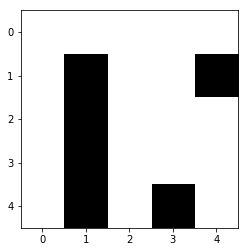

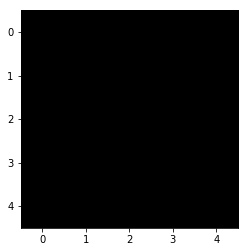

In [52]:
Simulation_op=simulation_op(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

#Affichage des opinions de départ
Opinions_start=Simulation_op[0]
fig=plt.figure()
im=plt.imshow(Opinions_start,cmap='binary',vmin=0,vmax=1)

#Affichage des opinions d'arrivée
Opinions_end=Simulation_op[-1]
fig=plt.figure()
im=plt.imshow(Opinions_end,cmap='binary',vmin=0,vmax=1)

#blanc = 0 ; noir = 1

### b) Représentation des convictions au début et à la fin de la simulation

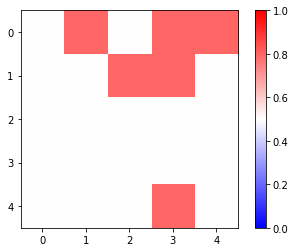

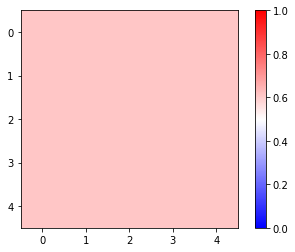

In [53]:
Simulation=simulation_p(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

#Affichage des convictions de départ
Convictions_start=Simulation[0]
fig=plt.figure()
im=plt.imshow(Convictions_start,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()

#Affichage des convictions de fin de simulation

Convictions_end=Simulation[-1]
fig=plt.figure()
im=plt.imshow(Convictions_end,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()

# CONSULTATION A DISTANCE

Dans cette deuxième partie, nous nous intéresserons à la transmission d'une fake news à distance, c'est-à-dire par le biais d'un organisme médiatique ou d'un réseau social. Des personnes physiquement éloignées pourront alors interagir.  

**Processus détaillé :**  
Comme évoqué dans la partie "Initialisation du système", le réseau virtuel nous fournit, pour chaque agent, la liste des autres agents qui voient la news si celui-ci la partage (on peut dire que c'est sa liste d'amis ou d'abonnés). Pour faire un parallèle avec la partie "Discussion physique", on peut considérer que c'est l'équivalent de la liste discussion.  
- **1ère étape : lancement de la fake news**  
Un média malveillant est choisi au hasard. Son opinion est alors mise à 1 et il partage la news à sa liste d'abonnés grâce à l'algorithme décrit ci-dessous.
- **2ème étape : partage de la fake news**  
Pour ce qui est du partage de l'information, le processus est semblable à celui de la discussion physique à quelques différences près.  
On met toujours à jour successivement les convictions puis les opinions selon plusieurs facteurs :
    - la **force de persuasion** jouera le même rôle que précédemment. Nous estimons que même à travers un réseau social ou un article, la force de persuasion a son rôle à jouer.
    - contrairement à la discussion physique où la conviction dépend exclusivement du voisinage, lorsqu'un agent se retrouve seul derrière son écran ou son journal, le rôle de la **crédibilité de la news** que nous nommerons "$news$" est prépondérant (on remarquera au passage que cette valeur (comprise entre 0 et 1) est la seule caractéristique propre à la news). La conviction $p$ de l'agent de force de persuasion $fp$ sera modifiée selon la loi suivante : $ p \leftarrow p + (1-fp)\cdot ( news - p ) $. En effet, plus sa force de persuasion sera faible, plus il sera enclin à croire à la news et sa conviction tendra alors plus fortement vers la valeur de la crédibilité de la news.
    - l'agent est également affecté par la **fréquence d'exposition antérieure** à la news, c'est-à-dire le nombre de fois où il a été confronté à la news par le biais de quelqu'un qui y croit. L'agent peut ainsi mesurer combien de personnes l'ont partagée en y croyant et pas en la démentant.

In [54]:
#Influence crébibilité news sur le p d'une personne

def influ_credib_news(news,p,fp):
    #news: crédibilité de la news
    i = p+(1-fp)*(news-p)
    return i

print(influ_credib_news(news,0.5,0.1),'\n')

def influ_partage(pop,res_virtu,partageur): #pop to get op,deja,fp,p ; res_virtu to get liste partage

    Liste_partage=res_virtu[partageur]
    op_p,deja_p,fp_p,p_p=pop[partageur]
    
    if deja_p==0:
        return pop
    
    P=[]   #liste des convictions des membres de la liste partage
    Fp=[]  #liste des forces de persuasion des membres de la liste partage
    i=0
    
    for k in Liste_partage:
        op_k,deja_k,fp_k,p_k=pop[k]
        P.append(p_k)
        Fp.append(fp_k)
        
    for a in Liste_partage:
        op_a,deja_a,fp_a,p_a=pop[a]
        p_a=influ_credib_news(news,p_a,fp_a)
        if fp_p>fp_a:
            p_a=p_a+fp_p*(p_p-p_a)
        if op_p==1:
            deja_a=deja_a+1
        pop[a]=op_a,deja_a,fp_a,p_a
    
    return pop

Partageur=np.random.choice(Noms_agents_avec)
print('Pop avant partage \n',Pop_ac_om,'\n')
print('Celui qui partage l\'info :', Partageur,'\n')
print('Amis de celui qui partage :', Reseau_virtuel[Partageur],'\n')
print('Pop après partage \n', influ_partage(Pop_ac_om, Reseau_virtuel, Partageur))

0.6101401739295284 

Pop avant partage 
 {'1': (0, 0, 0.10652141765137013, 0.5), '2': (0, 0, 0.8260130959805032, 0.5), '6': (0, 0, 0.9135807537276286, 0.5), '9': (0, 0, 0.9671751064842852, 0.5), '10': (0, 0, 0.12156485189861643, 0.5), '11': (0, 0, 0.695317654373246, 0.5), '12': (0, 0, 0.9936946376603758, 0.5), '15': (0, 0, 0.9439855107607662, 0.5), '16': (0, 0, 0.16166134009051458, 0.5), '18': (0, 0, 0.26319669281971736, 0.5), '19': (0, 0, 0.442757936050728, 0.5), '20': (0, 0, 0.9150595774392191, 0.5), '22': (0, 0, 0.6548311325919133, 0.5), '24': (0, 0, 0.7392190360058841, 0.5), '25': (0, 0, 0.2759917704330954, 0.5), 'XOM3': (0, 0, 0.9557165163927502, 0.6), 'OM4': (0, 0, 0.7643617713850371, 0.5), 'OM5': (0, 0, 0.918347215202465, 0.5), 'XOM7': (0, 0, 0.9570029741213969, 0.6), 'XOM8': (0, 0, 0.8959680672189809, 0.6), 'OM13': (0, 0, 0.8503609416238027, 0.5), 'XOM14': (0, 0, 0.8963584649410925, 0.6), 'OM17': (0, 0, 0.7313250913249498, 0.5), 'OM21': (0, 0, 0.7142333073095334, 0.5), 'OM23': 

In [55]:
#Lancement fake news
#choix aléatoire d'une média malveillant de la liste_xom comme le départ de la propagation du fake news

def lancement_fake_news(pop,list_xom):
    lanceur='XOM'+str(np.random.choice(list_xom))
    pop[lanceur]=(1,1,np.random.uniform(low=0.7,high=1.0),0.5)
    for xom in list_xom:
        if 'XOM'+str(xom)!=lanceur:
            pop['XOM'+str(xom)]=(0,0,np.random.uniform(low=0.7,high=1.0),0.6)
    return pop,lanceur

Pop_ap_lan,Lanceur=lancement_fake_news(Pop_ac_om, List_xom)
print('Lanceur :',Lanceur)
print('Population après le lancement du fake news : \n',Pop_ap_lan)

Lanceur : XOM7
Population après le lancement du fake news : 
 {'1': (0, 0, 0.10652141765137013, 0.5), '2': (0, 0, 0.8260130959805032, 0.5), '6': (0, 0, 0.9135807537276286, 0.5), '9': (0, 0, 0.9671751064842852, 0.5), '10': (0, 0, 0.12156485189861643, 0.5), '11': (0, 0, 0.695317654373246, 0.5), '12': (0, 0, 0.9936946376603758, 0.5), '15': (0, 0, 0.9439855107607662, 0.5), '16': (0, 0, 0.16166134009051458, 0.5), '18': (0, 0, 0.26319669281971736, 0.5), '19': (0, 0, 0.442757936050728, 0.5), '20': (0, 0, 0.9150595774392191, 0.5), '22': (0, 0, 0.6548311325919133, 0.5), '24': (0, 0, 0.7392190360058841, 0.5), '25': (0, 0, 0.2759917704330954, 0.5), 'XOM3': (0, 0, 0.7920017038377829, 0.6), 'OM4': (0, 0, 0.7643617713850371, 0.5), 'OM5': (0, 0, 0.918347215202465, 0.5), 'XOM7': (1, 1, 0.9374174497014853, 0.5), 'XOM8': (0, 0, 0.7652005639627217, 0.6), 'OM13': (0, 0, 0.8503609416238027, 0.5), 'XOM14': (0, 0, 0.8135324602702025, 0.6), 'OM17': (0, 0, 0.7313250913249498, 0.5), 'OM21': (0, 0, 0.71423330730

# II-) Simulation

In [56]:
Reseau_discu={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
Pop_ac_om=init_ac_om_et_xom(Reseau_discu,List_om,List_xom)
print('Matrice population :\n',Mat_pop_ac_om)

def simulation_op_distance(pop,res_virtu,names,n_1dim,steps,list_xom,mat_pop):
    """retourne la matrice des OPINIONS de la population après un certain nb d'étapes"""
    
    pop_ap_lan,lanceur=lancement_fake_news(pop,list_xom)
    results=[matrice_opinions(pop,names,n_1dim)]
    print('Lanceur :',lanceur)
    print('Liste d\'abonnés du lanceur :',res_virtu[lanceur])
    
    for simu in range(steps):
        if simu==0:
            i=lanceur
        else:
            i=np.random.choice(names)
        Res_p_changé=influ_partage(pop,res_virtu,i)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        for e in mat_pop.ravel():
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        results.append(Op_final.copy())
    return results

Simulation_op=simulation_op_distance(Pop_ac_om,Reseau_virtuel,Noms_agents_avec,N_1dim,steps,List_xom,Mat_pop_ac_om)
Simulation_op

Matrice population :
 [['9' '15' 'XOM7' '11' 'OM17']
 ['OM13' '10' '22' '16' 'XOM8']
 ['OM4' 'XOM3' '18' '20' '19']
 ['12' '24' 'OM5' '25' 'XOM14']
 ['OM21' '2' '1' 'OM23' '6']]
Lanceur : XOM8
Liste d'abonnés du lanceur : ['OM13', '15', 'OM23', '20', '10', 'OM21', 'OM17', '16', 'OM4', '24', 'OM5', '6']


[array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), array([[0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 0, 1, 0],
        [0, 1, 1, 0, 1],
        [1, 0, 0, 1, 1]]), array([[0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [1, 0, 0, 1, 1]]), array([[1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1]]), array([[1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), array([[1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 

In [57]:
Reseau_discu={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
Pop_ac_om=init_ac_om_et_xom(Reseau_discu,List_om,List_xom)
print('Matrice population :\n',Mat_pop_ac_om)

def simulation_p_distance(pop,res_virtu,names,n_1dim,steps,list_xom,mat_pop):
    """retourne la matrice des CONVICTIONS de la population après un certain nb d'étapes"""
    
    pop_ap_lan,lanceur=lancement_fake_news(pop,list_xom)
    results=[matrice_convic(pop_ap_lan,names,n_1dim)]
    print('Lanceur :',lanceur)
    print('Liste d\'abonnés du lanceur :',res_virtu[lanceur])
    
    for simu in range(steps):
        if simu==0:
            i=lanceur
        else:
            i=np.random.choice(names)
        Res_p_changé=influ_partage(pop,res_virtu,i)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        P=[]
        for e in mat_pop.ravel():
            op,deja,fp,p=Res_p_changé[e]
            P.append(p)
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(P_final.copy())
        
    return results

Simulation_p=simulation_p_distance(Pop_ac_om,Reseau_virtuel,Noms_agents_avec,N_1dim,steps,List_xom,Mat_pop_ac_om)
Simulation_p

Matrice population :
 [['9' '15' 'XOM7' '11' 'OM17']
 ['OM13' '10' '22' '16' 'XOM8']
 ['OM4' 'XOM3' '18' '20' '19']
 ['12' '24' 'OM5' '25' 'XOM14']
 ['OM21' '2' '1' 'OM23' '6']]
Lanceur : XOM8
Liste d'abonnés du lanceur : ['OM13', '15', 'OM23', '20', '10', 'OM21', 'OM17', '16', 'OM4', '24', 'OM5', '6']


[array([[0.5, 0.5, 0.6, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.6, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.6],
        [0.5, 0.5, 0.5, 0.5, 0.5]]),
 array([[0.5       , 0.50751067, 0.6       , 0.5       , 0.50552541],
        [0.50483598, 0.50958364, 0.5       , 0.50862137, 0.5       ],
        [0.51935888, 0.6       , 0.5       , 0.51354266, 0.5       ],
        [0.5       , 0.50819306, 0.50381638, 0.5       , 0.6       ],
        [0.50951437, 0.5       , 0.5       , 0.50304441, 0.50610322]]),
 array([[0.5       , 0.51091098, 0.51467159, 0.51572508, 0.50552541],
        [0.50978918, 0.50958364, 0.5       , 0.50862137, 0.50904377],
        [0.51935888, 0.51444836, 0.5       , 0.51327265, 0.50104694],
        [0.5       , 0.50819306, 0.50381638, 0.5       , 0.6       ],
        [0.50951437, 0.51081762, 0.51540092, 0.50304441, 0.50610322]]),
 array([[0.5       , 0.51091098, 0.51467159, 0.51572508, 0.50552541],
        [0.50978918, 0.50958364, 0.5       , 0.50

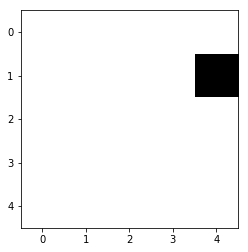

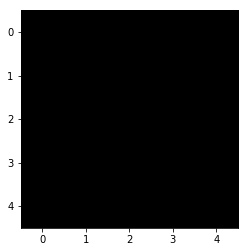

In [58]:
#Affichage des opinions de départ
Opinions_start=Simulation_op[0]
fig=plt.figure()
im=plt.imshow(Opinions_start,cmap='binary',vmin=0,vmax=1)

#Affichage des opinions d'arrivée
Opinions_end=Simulation_op[-1]
fig=plt.figure()
im=plt.imshow(Opinions_end,cmap='binary',vmin=0,vmax=1)

#blanc = 0 ; noir = 1

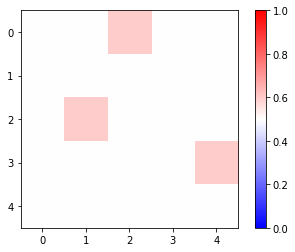

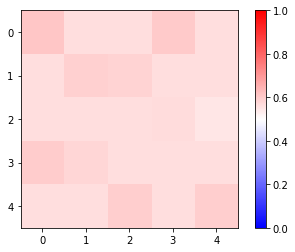

In [59]:
#Affichage des convictions de départ
Convictions_start=Simulation_p[0]
fig=plt.figure()
im=plt.imshow(Convictions_start,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()

#Affichage des convictions de fin de simulation

Convictions_end=Simulation_p[-1]
fig=plt.figure()
im=plt.imshow(Convictions_end,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()